# ЯНДЕКС.АФИША: Исследовательский анализ данных

**Автор:** Карташов Владимир

**Дата:** 18.11.2025 г.

### Цель проекта: 

Провести исследовательский анализ данных для того, чтобы выявить общие изменения в пользовательском спросе за указанный период времени. В ходе анализа необходимо выявить причины изменений и выяснить, какие события, площадки и организаторы являются лидерами по привлечению аудитории, а также проверить гипотезу о том, что пользователи мобильных устройств активнее покупают билеты, чем пользователи ПК. 

### Описание данных:

Первый датасет **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:
- **order_id** — уникальный идентификатор заказа.
- **user_id** — уникальный идентификатор пользователя.
- **created_dt_msk** — дата создания заказа (московское время).
- **created_ts_msk** — дата и время создания заказа (московское время).
- **event_id** — идентификатор мероприятия из таблицы events.
- **cinema_circuit** — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- **age_limit** — возрастное ограничение мероприятия.
- **currency_code** — валюта оплаты, например rub для российских рублей.
- **device_type_canonical** — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- **revenue** — выручка от заказа.
- **service_name** — название билетного оператора.
- **tickets_count** — количество купленных билетов.
- **total** — общая сумма заказа.
- **days_since_prev** - количество дней с предыдущей покупки для каждого пользователя. 

Второй датасет **final_tickets_events_df** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.Датасет содержит такие поля:
- **event_id** — уникальный идентификатор мероприятия.
- **event_name** — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- **event_type_description** — описание типа мероприятия.
- **event_type_main** — основной тип мероприятия: театральная постановка, концерт и так далее.
- **organizers** — организаторы мероприятия.
- **region_name** — название региона.
- **city_name** — название города.
- **venue_id** — уникальный идентификатор площадки.
- **venue_name** — название площадки.
- **venue_address** — адрес площадки.

Датасет **final_tickets_tenge_df.csv** с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
- **nominal** — номинал (100 тенге).
- **data** — дата.
- **curs** — курс тенге к рублю.
- **cdx** — обозначение валюты (kzt).

### Структура проекта: 

- Предобработка данных
 - Загрузка данных
 - Проверка данных на пропуски
 - Очистка данных
 - Проверка данных на дубликаты
- Анализ динамики мероприятий
- Статистический анализ данных
- Общий вывод и рекомендации

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

После загрузки данных и создания датафреймов, знакомимся с данными.

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [4]:
orders.head()

order_id          user_id created_dt_msk       created_ts_msk  event_id  \
0   4359165  0002849b70a3ce2     2024-08-20  2024-08-20 16:08:03    169230   
1   7965605  0005ca5e93f2cf4     2024-07-23  2024-07-23 18:36:24    237325   
2   7292370  0005ca5e93f2cf4     2024-10-06  2024-10-06 13:56:02    578454   
3   1139875  000898990054619     2024-07-13  2024-07-13 19:40:48    387271   
4    972400  000898990054619     2024-10-04  2024-10-04 22:33:15    509453   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  \
0            нет         16           rub                mobile  1521.94   
1            нет          0           rub                mobile   289.45   
2            нет          0           rub                mobile  1258.57   
3            нет          0           rub                mobile     8.49   
4            нет         18           rub                mobile  1390.41   

         service_name  tickets_count     total  days_since_prev  
0        Край билетов              4  10870.99              NaN  
1           Мой билет              2   2067.51              NaN  
2         За билетом!              4  13984.16             75.0  
3         Лови билет!              2    212.28              NaN  
4  Билеты без проблем              3  10695.43             83.0

**Промежуточный вывод:** В таблице с заказами представлено 290849 строк и 14 столбцов. Пропусков нет. Объем таблицы достаточно большой, так что необходимо будет впоследствии снизить разрядность. В двух столбцах неправильно указан тип данных, нужно будет поменять на даты. 

In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [6]:
events.head()

event_id                            event_name event_type_description  \
0      4436  e4f26fba-da77-4c61-928a-6c3e434d793f              спектакль   
1      5785  5cc08a60-fdea-4186-9bb2-bffc3603fb77              спектакль   
2      8817  8e379a89-3a10-4811-ba06-ec22ebebe989              спектакль   
3      8849  682e3129-6a32-4952-9d8a-ef7f60d4c247              спектакль   
4      8850  d6e99176-c77f-4af0-9222-07c571f6c624              спектакль   

  event_type_main organizers           region_name   city_name  city_id  \
0           театр      №4893  Североярская область      Озёрск        2   
1           театр      №1931  Светополянский округ   Глиноград       54   
2           театр      №4896  Североярская область      Озёрск        2   
3           театр      №4960    Каменевский регион  Глиногорск      213   
4           театр      №4770      Лесодальний край  Родниковец       55   

   venue_id                               venue_name             venue_address  
0      1600  Кладбище искусств "Проблема" и партнеры   наб. Загородная, д. 785  
1      2196         Лекции по искусству "Свет" Групп       ул. Ягодная, д. 942  
2      4043                Кинокомитет "Золотая" Инк  ш. Коммуны, д. 92 стр. 6  
3      1987              Выставка ремесел "Свет" Лтд    пер. Набережный, д. 35  
4      4230       Фестивальный проект "Листья" Групп       пер. Проезжий, д. 9

**Промежуточные выводы:** Таблица с событиями представлена 22427 строками и 11 столбцами. Пустых строк нет, но необходимо также обратить внимание на разрядность отдельных столбцов.  

## Предобработка данных

### Проверка данных на пропуски

Объединим данные в один датафрейм, чтобы было удобнее не только работать, но и обрабатыать данные.

In [7]:
frame = pd.merge(orders, events, on = 'event_id', how = 'left')
frame.head()

order_id          user_id created_dt_msk       created_ts_msk  event_id  \
0   4359165  0002849b70a3ce2     2024-08-20  2024-08-20 16:08:03    169230   
1   7965605  0005ca5e93f2cf4     2024-07-23  2024-07-23 18:36:24    237325   
2   7292370  0005ca5e93f2cf4     2024-10-06  2024-10-06 13:56:02    578454   
3   1139875  000898990054619     2024-07-13  2024-07-13 19:40:48    387271   
4    972400  000898990054619     2024-10-04  2024-10-04 22:33:15    509453   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  ...  \
0            нет         16           rub                mobile  1521.94  ...   
1            нет          0           rub                mobile   289.45  ...   
2            нет          0           rub                mobile  1258.57  ...   
3            нет          0           rub                mobile     8.49  ...   
4            нет         18           rub                mobile  1390.41  ...   

                             event_name  event_type_description  \
0  f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad               спектакль   
1  40efeb04-81b7-4135-b41f-708ff00cc64c                 событие   
2  01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca            цирковое шоу   
3  2f638715-8844-466c-b43f-378a627c419f                выставка   
4  10d805d3-9809-4d8a-834e-225b7d03f95d                     шоу   

   event_type_main  organizers           region_name    city_name city_id  \
0            театр       №3322    Каменевский регион   Глиногорск   213.0   
1         выставки       №4850    Каменевский регион   Глиногорск   213.0   
2           другое       №1540    Каменевский регион   Глиногорск   213.0   
3           другое       №5049  Североярская область       Озёрск     2.0   
4          стендап        №832      Озернинский край  Родниковецк   240.0   

  venue_id                                     venue_name  \
0   3972.0               Сценический центр "Деталь" Групп   
1   2941.0      Музыкальная школа для детей "Аккаунт" Лтд   
2   4507.0                 Училище искусств "Нирвана" Инк   
3   3574.0  Театр альтернативного искусства "Ода" Лимитед   
4   1896.0               Театр кукол "Огни" Инкорпорэйтед   

                         venue_address  
0  алл. Машиностроителей, д. 19 стр. 6  
1             алл. Шмидта, д. 9 стр. 4  
2               алл. Юбилейная, д. 5/6  
3          алл. Есенина, д. 243 к. 3/8  
4         ш. Набережное, д. 595 стр. 8  

[5 rows x 24 columns]

In [8]:
null_value = frame.isna().sum()
print(null_value)

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
dtype: int64


Посмотрим на пропуски. Вычислим их долю. 

In [9]:
percent = null_value/len(frame)*100
print(percent.round(2))

order_id                  0.00
user_id                   0.00
created_dt_msk            0.00
created_ts_msk            0.00
event_id                  0.00
cinema_circuit            0.00
age_limit                 0.00
currency_code             0.00
device_type_canonical     0.00
revenue                   0.00
service_name              0.00
tickets_count             0.00
total                     0.00
days_since_prev           7.54
event_name                0.08
event_type_description    0.08
event_type_main           0.08
organizers                0.08
region_name               0.08
city_name                 0.08
city_id                   0.08
venue_id                  0.08
venue_name                0.08
venue_address             0.08
dtype: float64


Из полученных данных видим, что в столбце days-since_prev - 7.54 % пропусков (21940), а в столбцах event_name, event_type_description, event_type_main, organizers, region_name, city_name, city_id, venue_id, venue_name, venue_address - 0.08 % пропусков (238). Заполним значением unknown текстовые столбцы, а значением -1 - числовые для того, чтобы не повредить точности расчетов.

In [10]:
event_cols = ['event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name','city_name', 'venue_name', 
              'venue_address']
frame[event_cols] = frame[event_cols].fillna("unknown")

In [11]:
frame['city_id'] = frame['city_id'].fillna(-1).astype(int)
frame['venue_id'] = frame['venue_id'].fillna(-1).astype(int)

In [12]:
na_count = pd.DataFrame({'Количество пропусков': frame.isna().sum(),
                           'Доля пропусков (%)': (frame.isna().mean() * 100).round(2)})
display(na_count)

Количество пропусков  Доля пропусков (%)
order_id                                   0                0.00
user_id                                    0                0.00
created_dt_msk                             0                0.00
created_ts_msk                             0                0.00
event_id                                   0                0.00
cinema_circuit                             0                0.00
age_limit                                  0                0.00
currency_code                              0                0.00
device_type_canonical                      0                0.00
revenue                                    0                0.00
service_name                               0                0.00
tickets_count                              0                0.00
total                                      0                0.00
days_since_prev                        21940                7.54
event_name                                 0                0.00
event_type_description                     0                0.00
event_type_main                            0                0.00
organizers                                 0                0.00
region_name                                0                0.00
city_name                                  0                0.00
city_id                                    0                0.00
venue_id                                   0                0.00
venue_name                                 0                0.00
venue_address                              0                0.00

In [13]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

Мы видим, что типы данных не соответствуют данным в столбцах. Плюс к этому стоит понизить разрядность в некоторых столбцах.

In [14]:
frame['created_dt_msk'] = pd.to_datetime(frame['created_dt_msk'])
frame['created_ts_msk'] = pd.to_datetime(frame['created_ts_msk'])

In [15]:
cols = ['order_id', 'event_id', 'age_limit', 'tickets_count', 'city_id', 'venue_id']

for col in cols:
    frame[col] = pd.to_numeric(frame[col], downcast='integer')

In [16]:
cols = ['revenue', 'total', 'days_since_prev']

for col in cols:
    frame[col] = pd.to_numeric(frame[col], downcast='float')

In [17]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int32         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int32         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int8          
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int8          
 12  total                   290849

In [18]:
frame.head()

order_id          user_id created_dt_msk      created_ts_msk  event_id  \
0   4359165  0002849b70a3ce2     2024-08-20 2024-08-20 16:08:03    169230   
1   7965605  0005ca5e93f2cf4     2024-07-23 2024-07-23 18:36:24    237325   
2   7292370  0005ca5e93f2cf4     2024-10-06 2024-10-06 13:56:02    578454   
3   1139875  000898990054619     2024-07-13 2024-07-13 19:40:48    387271   
4    972400  000898990054619     2024-10-04 2024-10-04 22:33:15    509453   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  ...  \
0            нет         16           rub                mobile  1521.94  ...   
1            нет          0           rub                mobile   289.45  ...   
2            нет          0           rub                mobile  1258.57  ...   
3            нет          0           rub                mobile     8.49  ...   
4            нет         18           rub                mobile  1390.41  ...   

                             event_name  event_type_description  \
0  f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad               спектакль   
1  40efeb04-81b7-4135-b41f-708ff00cc64c                 событие   
2  01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca            цирковое шоу   
3  2f638715-8844-466c-b43f-378a627c419f                выставка   
4  10d805d3-9809-4d8a-834e-225b7d03f95d                     шоу   

   event_type_main  organizers           region_name    city_name city_id  \
0            театр       №3322    Каменевский регион   Глиногорск     213   
1         выставки       №4850    Каменевский регион   Глиногорск     213   
2           другое       №1540    Каменевский регион   Глиногорск     213   
3           другое       №5049  Североярская область       Озёрск       2   
4          стендап        №832      Озернинский край  Родниковецк     240   

  venue_id                                     venue_name  \
0     3972               Сценический центр "Деталь" Групп   
1     2941      Музыкальная школа для детей "Аккаунт" Лтд   
2     4507                 Училище искусств "Нирвана" Инк   
3     3574  Театр альтернативного искусства "Ода" Лимитед   
4     1896               Театр кукол "Огни" Инкорпорэйтед   

                         venue_address  
0  алл. Машиностроителей, д. 19 стр. 6  
1             алл. Шмидта, д. 9 стр. 4  
2               алл. Юбилейная, д. 5/6  
3          алл. Есенина, д. 243 к. 3/8  
4         ш. Набережное, д. 595 стр. 8  

[5 rows x 24 columns]

**Промежуточные выводы:** Пропуски были обработаны и заменены другими значениями, чтобы не нарушать подсчеты. 

### Изучение значений в ключевых столбцах


In [19]:
cat_cols = ['cinema_circuit', 'currency_code', 'device_type_canonical', 
            'service_name', 'event_type_main', 'region_name', 'city_name']

for col in cat_cols:
    print(f"Уникальные значения в {col}:")
    display(frame[col].value_counts(dropna=False).head(10))

Уникальные значения в cinema_circuit:


cinema_circuit
нет           289451
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: count, dtype: int64

Уникальные значения в currency_code:


currency_code
rub    285780
kzt      5069
Name: count, dtype: int64

Уникальные значения в device_type_canonical:


device_type_canonical
mobile     232679
desktop     58170
Name: count, dtype: int64

Уникальные значения в service_name:


service_name
Билеты без проблем    63709
Лови билет!           41126
Билеты в руки         40364
Мой билет             34843
Облачко               26642
Лучшие билеты         17795
Весь в билетах        16849
Прачечная             10273
Край билетов           6207
Тебе билет!            5228
Name: count, dtype: int64

Уникальные значения в event_type_main:


event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
unknown        238
Name: count, dtype: int64

Уникальные значения в region_name:


region_name
Каменевский регион         91058
Североярская область       44049
Широковская область        16457
Медовская область          13901
Озернинский край           10476
Светополянский округ        7607
Малиновоярский округ        6618
Речиновская область         6293
Солнечноземская область     6288
Яблоневская область         6181
Name: count, dtype: int64

Уникальные значения в city_name:


city_name
Глиногорск      89446
Озёрск          43910
Радужсвет       13711
Радужнополье     8741
Верховино        6579
Дальнесветск     6293
Глинополье       6196
Светополье       5993
Глиноград        5934
Лесоярич         5831
Name: count, dtype: int64

In [20]:
num_cols = ['revenue', 'tickets_count', 'total', 'age_limit']

for col in num_cols:
    print(f"\nСтатистика для {col}:")
    display(frame[col].describe())


Статистика для revenue:


count    290849.000000
mean        625.083054
std        1227.316214
min         -90.760000
25%         116.790000
50%         355.340000
75%         809.750000
max       81174.540000
Name: revenue, dtype: float64


Статистика для tickets_count:


count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


Статистика для total:


count    290849.000000
mean       7526.465613
std       15328.267730
min        -358.850000
25%        2156.870000
50%        4771.390000
75%        8955.950000
max      811745.400000
Name: total, dtype: float64


Статистика для age_limit:


count    290849.000000
mean         10.211278
std           6.518124
min           0.000000
25%           6.000000
50%          12.000000
75%          16.000000
max          18.000000
Name: age_limit, dtype: float64

In [21]:
frame.groupby('currency_code')['revenue'].describe()

count         mean          std    min       25%      50%  \
currency_code                                                                 
kzt              5069.0  4995.206767  4916.752776   0.00  518.1000  3698.83   
rub            285780.0   547.568333   871.524559 -90.76  113.8275   346.10   

                   75%       max  
currency_code                     
kzt            7397.66  26425.86  
rub             791.70  81174.54

In [22]:
rub_df = frame[frame['currency_code'] == 'rub'].copy()
kzt_df = frame[frame['currency_code'] == 'kzt'].copy()

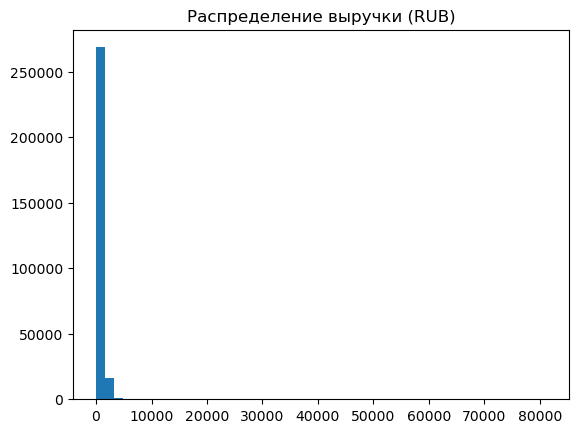

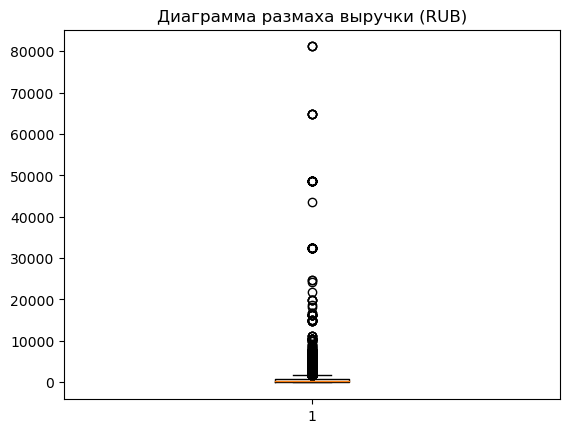

In [23]:
plt.hist(rub_df['revenue'], bins=50)
plt.title('Распределение выручки (RUB)')
plt.show()

plt.boxplot(rub_df['revenue'])
plt.title('Диаграмма размаха выручки (RUB)')
plt.show()

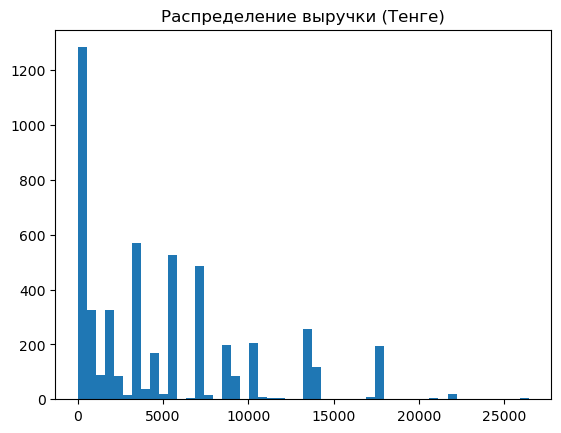

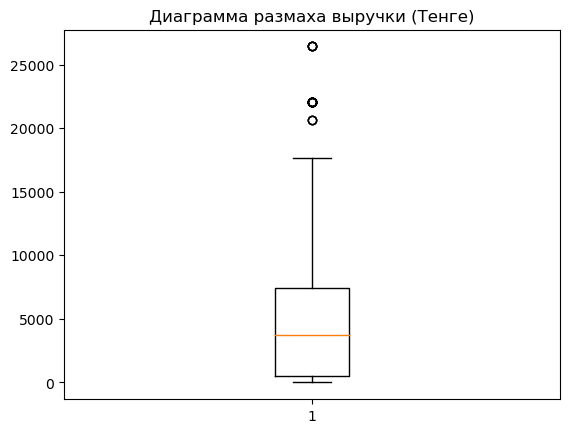

In [24]:
plt.hist(kzt_df['revenue'], bins=50)
plt.title('Распределение выручки (Тенге)')
plt.show()

plt.boxplot(kzt_df['revenue'])
plt.title('Диаграмма размаха выручки (Тенге)')
plt.show()

In [25]:
print("Статистика для рублевых операций: ")
print(rub_df['revenue'].describe())
print("Статистика для операций в тенге: ")
print(kzt_df['revenue'].describe())

Статистика для рублевых операций: 
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64
Статистика для операций в тенге: 
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64


В столбце **'revenue'** мы можем видеть следующее:

**rub:**

- Сильное смещение: Среднее (547) > медианы (346) — есть редкие, но очень крупные заказы (максимум 81,174), которые сильно искажают распределение.
- Отрицательное минимальное значение (-90.76): Видимо это возврат или аномалия
- Дальнейший анализ лучше проводить на данных, где будут отфильтрованы выбросы

**kzt:** 

- Среднее (4,995) > медианы (3,699), значит, есть редкие, но крупные заказы, которые влияют на показатели среднего.
- Широкий разброс: Стандартное отклонение близко к среднему, что указывает на значительную вариативность данных.
- 25% заказов ≤ 518, а 75% заказов ≤ 7,397 — большинство заказов сосредоточено в нижней части диапазона. Более крупные типичные заказы.
- Распределение ближе к "нормальному", но тоже с перекосом.

In [26]:
perc_rub = rub_df['revenue'].quantile(0.99)
rub_df_filtered = rub_df[rub_df['revenue'] <= perc_rub]

perc_kzt = kzt_df['revenue'].quantile(0.99)
kzt_df_filtered = kzt_df[kzt_df['revenue'] <= perc_kzt]

Теперь посмотрим на распределение количества билетов.

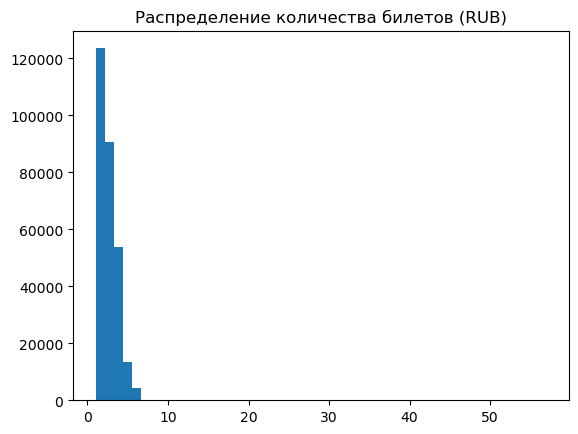

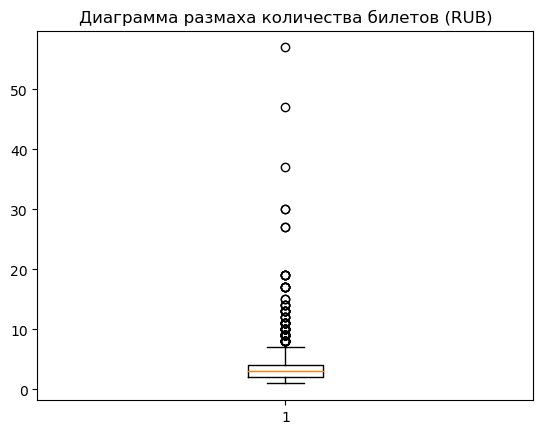

In [27]:
plt.hist(rub_df['tickets_count'], bins=50)
plt.title('Распределение количества билетов (RUB)')
plt.show()

plt.boxplot(rub_df['tickets_count'])
plt.title('Диаграмма размаха количества билетов (RUB)')
plt.show()

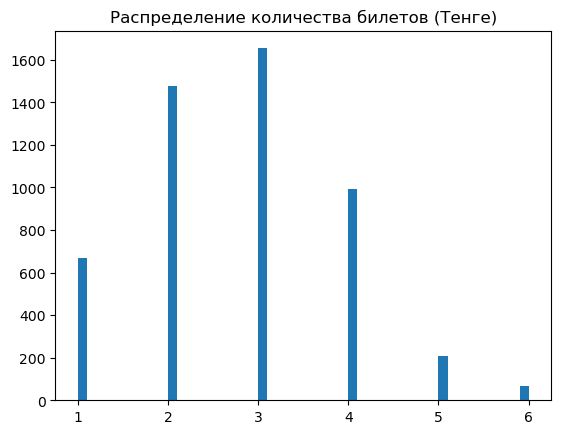

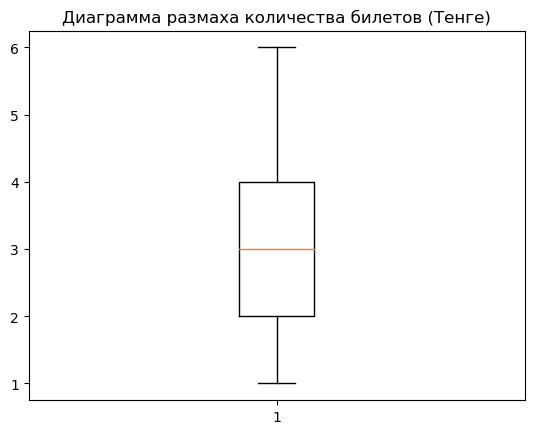

In [28]:
plt.hist(kzt_df['tickets_count'], bins=50)
plt.title('Распределение количества билетов (Тенге)')
plt.show()

plt.boxplot(kzt_df['tickets_count'])
plt.title('Диаграмма размаха количества билетов (Тенге)')
plt.show()

In [29]:
print(rub_df['tickets_count'].describe())
print(kzt_df['tickets_count'].describe())

count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


Здесь мы видим сильный перекос в количестве билетов за рубли. При этом распределение билетов за тенге куда более равномерное.

In [30]:
percentiles_rub = (frame[frame['currency_code'] == 'rub']['revenue']
                  .quantile(0.99).round(2)) 
display(percentiles_rub)

2569.59

Возьмем данные по 99 перцентилю.

In [31]:
filtered_frame = frame[((frame['currency_code'] == 'rub') &  
                        (frame['revenue'] <= percentiles_rub)) | (frame['currency_code'] == 'kzt')]

In [32]:
exacts_duplicates = filtered_frame[filtered_frame.duplicated()]
print(f"Полных дубликатов: {len(exacts_duplicates)}")

Полных дубликатов: 0


In [33]:
dupl_cols = [
    'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
    'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
    'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
    'event_name', 'event_type_description', 'event_type_main', 'organizers',
    'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address'
]

potential_dupl = (filtered_frame.groupby(dupl_cols).size().reset_index(name='duplicate_count'))
fin_dupl = potential_dupl[potential_dupl['duplicate_count'] > 1]

print(f"Потенциальных неявных дубликатов: {fin_dupl.shape[0]}")

Потенциальных неявных дубликатов: 28


Неявных дубликатов 28, что в сравнении с количеством строк данных довольно мало. Но тем не менее, чтобы избежать ошибок в расчетах - неявные дубликаты также следует обработать.

In [34]:
clean_frame = filtered_frame.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
          'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
          'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
          'event_name', 'event_type_description', 'event_type_main', 'organizers',
          'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
          'venue_address'], keep='first')

In [35]:
dupl_cols = [
    'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
    'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
    'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
    'event_name', 'event_type_description', 'event_type_main', 'organizers',
    'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address'
]

potential_dupl2 = (clean_frame.groupby(dupl_cols).size().reset_index(name='duplicate_count'))
fin_dupl2 = potential_dupl2[potential_dupl2['duplicate_count'] > 1]

print(f"Потенциальных неявных дубликатов: {fin_dupl2.shape[0]}")

Потенциальных неявных дубликатов: 0


In [36]:
clean_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287961 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287961 non-null  int32         
 1   user_id                 287961 non-null  object        
 2   created_dt_msk          287961 non-null  datetime64[ns]
 3   created_ts_msk          287961 non-null  datetime64[ns]
 4   event_id                287961 non-null  int32         
 5   cinema_circuit          287961 non-null  object        
 6   age_limit               287961 non-null  int8          
 7   currency_code           287961 non-null  object        
 8   device_type_canonical   287961 non-null  object        
 9   revenue                 287961 non-null  float64       
 10  service_name            287961 non-null  object        
 11  tickets_count           287961 non-null  int8          
 12  total                   287961 non-

Приведем в таблице тенге колонку с датой к необходимому типу данных. И после этого объединим с основной таблицей.

In [37]:
tenge['data'] = pd.to_datetime(tenge['data'])

In [38]:
clean_frame = pd.merge(clean_frame, tenge,
           left_on='created_dt_msk',
           right_on='data',
           how='left')

In [39]:
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return (row['revenue'] * row['nominal']) / row['curs']
    else:
        return row['revenue']

clean_frame['revenue_rub'] = clean_frame.apply(convert_to_rub, axis=1)

In [40]:
clean_frame.head()

order_id          user_id created_dt_msk      created_ts_msk  event_id  \
0   4359165  0002849b70a3ce2     2024-08-20 2024-08-20 16:08:03    169230   
1   7965605  0005ca5e93f2cf4     2024-07-23 2024-07-23 18:36:24    237325   
2   7292370  0005ca5e93f2cf4     2024-10-06 2024-10-06 13:56:02    578454   
3   1139875  000898990054619     2024-07-13 2024-07-13 19:40:48    387271   
4    972400  000898990054619     2024-10-04 2024-10-04 22:33:15    509453   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  ...  \
0            нет         16           rub                mobile  1521.94  ...   
1            нет          0           rub                mobile   289.45  ...   
2            нет          0           rub                mobile  1258.57  ...   
3            нет          0           rub                mobile     8.49  ...   
4            нет         18           rub                mobile  1390.41  ...   

     city_name  city_id  venue_id  \
0   Глиногорск      213      3972   
1   Глиногорск      213      2941   
2   Глиногорск      213      4507   
3       Озёрск        2      3574   
4  Родниковецк      240      1896   

                                      venue_name  \
0               Сценический центр "Деталь" Групп   
1      Музыкальная школа для детей "Аккаунт" Лтд   
2                 Училище искусств "Нирвана" Инк   
3  Театр альтернативного искусства "Ода" Лимитед   
4               Театр кукол "Огни" Инкорпорэйтед   

                         venue_address       data nominal     curs  cdx  \
0  алл. Машиностроителей, д. 19 стр. 6 2024-08-20     100  18.6972  kzt   
1             алл. Шмидта, д. 9 стр. 4 2024-07-23     100  18.3419  kzt   
2               алл. Юбилейная, д. 5/6 2024-10-06     100  19.6475  kzt   
3          алл. Есенина, д. 243 к. 3/8 2024-07-13     100  18.5010  kzt   
4         ш. Набережное, д. 595 стр. 8 2024-10-04     100  19.6648  kzt   

  revenue_rub  
0     1521.94  
1      289.45  
2     1258.57  
3        8.49  
4     1390.41  

[5 rows x 29 columns]

In [41]:
clean_frame['one_ticket_revenue_rub'] = clean_frame['revenue_rub'] / clean_frame['tickets_count']
display(clean_frame[['revenue_rub', 'tickets_count', 'one_ticket_revenue_rub']].head())

revenue_rub  tickets_count  one_ticket_revenue_rub
0      1521.94              4                380.4850
1       289.45              2                144.7250
2      1258.57              4                314.6425
3         8.49              2                  4.2450
4      1390.41              3                463.4700

In [42]:
clean_frame['month'] = clean_frame['created_dt_msk'].dt.month
season_dict = {1:'зима',2: 'зима', 3: 'весна', 4: 'весна', 5:'весна', 6: 'лето',7: 'лето', 8: 'лето',9: 'осень',10: 'осень', 11: 'осень', 12: 'зима'}
clean_frame['season'] = clean_frame['month'].map(season_dict).astype('category')

In [43]:
clean_frame.head()

order_id          user_id created_dt_msk      created_ts_msk  event_id  \
0   4359165  0002849b70a3ce2     2024-08-20 2024-08-20 16:08:03    169230   
1   7965605  0005ca5e93f2cf4     2024-07-23 2024-07-23 18:36:24    237325   
2   7292370  0005ca5e93f2cf4     2024-10-06 2024-10-06 13:56:02    578454   
3   1139875  000898990054619     2024-07-13 2024-07-13 19:40:48    387271   
4    972400  000898990054619     2024-10-04 2024-10-04 22:33:15    509453   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  ...  \
0            нет         16           rub                mobile  1521.94  ...   
1            нет          0           rub                mobile   289.45  ...   
2            нет          0           rub                mobile  1258.57  ...   
3            нет          0           rub                mobile     8.49  ...   
4            нет         18           rub                mobile  1390.41  ...   

                                      venue_name  \
0               Сценический центр "Деталь" Групп   
1      Музыкальная школа для детей "Аккаунт" Лтд   
2                 Училище искусств "Нирвана" Инк   
3  Театр альтернативного искусства "Ода" Лимитед   
4               Театр кукол "Огни" Инкорпорэйтед   

                         venue_address       data  nominal     curs  cdx  \
0  алл. Машиностроителей, д. 19 стр. 6 2024-08-20      100  18.6972  kzt   
1             алл. Шмидта, д. 9 стр. 4 2024-07-23      100  18.3419  kzt   
2               алл. Юбилейная, д. 5/6 2024-10-06      100  19.6475  kzt   
3          алл. Есенина, д. 243 к. 3/8 2024-07-13      100  18.5010  kzt   
4         ш. Набережное, д. 595 стр. 8 2024-10-04      100  19.6648  kzt   

  revenue_rub one_ticket_revenue_rub month season  
0     1521.94               380.4850     8   лето  
1      289.45               144.7250     7   лето  
2     1258.57               314.6425    10  осень  
3        8.49                 4.2450     7   лето  
4     1390.41               463.4700    10  осень  

[5 rows x 32 columns]

**Промежуточные выводы:** 

- Объединены датафреймы `orders`, `events` в один dataframe - `frame`
- Пропуски: `days_since_prev` ~ 8%, могли быть образованы по причине отсутствия покупок у пользователей - оставлены без изменений, чтобы избежать искажения данныe; в строковых столбцах `event_name`, `event_type_description`, `event_type_main`, `organizers`, `region_name`, `city_name`, `venue_name`, `venue_address`, для которых event_id не найдены в объединенном фрейме - заменены на `unknown`, в  столбцах с индентификаторами `city_id`, `venue_id` - заменены на "заглушку": -1.
- Столбцы с датами `created_dt_msk`,`created_ts_msk`, `data` преобразованы в тип datetime. 
- Оптимизирована размерность во всех нужных столбцах`
- Категориальные данные в столбцах `cinema_circuit`, `service_name`, `region_name`, `city_name` приведены к нижнему регистру
- В количественных столбцах `revenue` и `total` c выручкой и общей суммой заказа выявлены отрицательные значения, которые могли быть образованы в результате возвратов битетов
- По столбцу  `revenue` с выручкой отфильтрованы данные до 99-го перцентиля, исключив выбросы
- Дубликаты: явных нет, неявные - 28 (удалены)
- Созданы новые столбцы: `revenue_rub` — выручка с заказа к единой валюте (российский рубль),`one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие, `month` — месяц оформления заказа, `season` — сезон 

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

Найдем количество заказов для каждого месяца чтобы узнать - влияет ли сезонность на увеличение количества заказов.

In [44]:
monthly_orders = clean_frame.groupby('month')['order_id'].count()
display(monthly_orders.to_frame('Количество заказов').rename_axis('Месяц'))

Количество заказов
Месяц                    
6                   34372
7                   40410
8                   44572
9                   69333
10                  99274

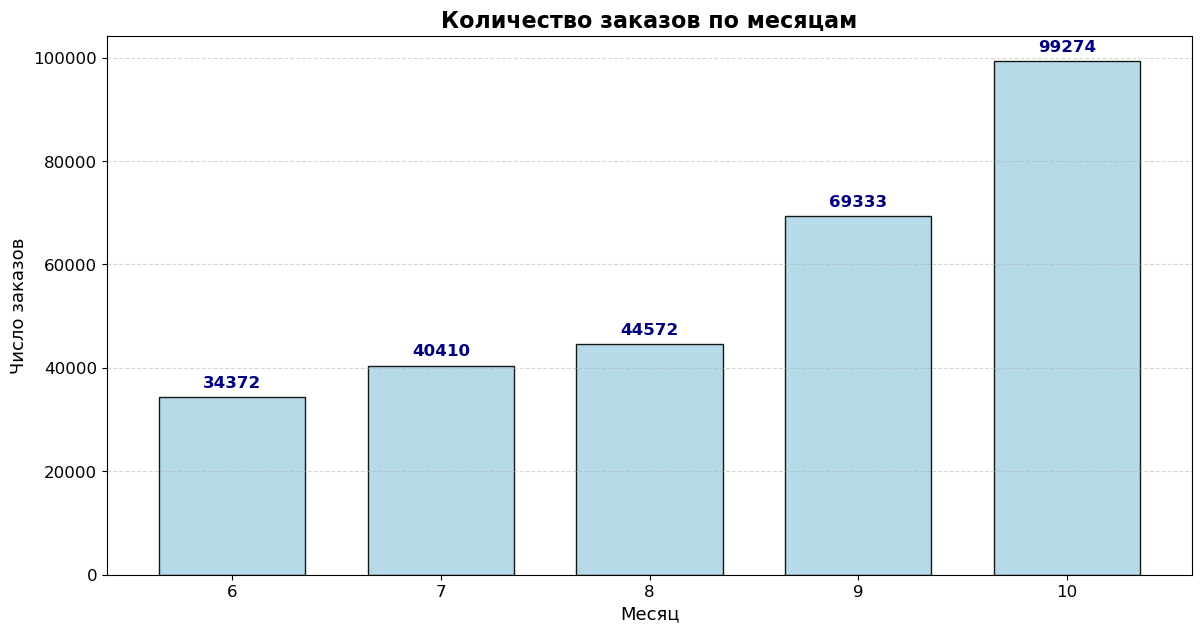

In [45]:
plt.figure(figsize=(14, 7))
ax = monthly_orders.plot(
    kind='bar',
    color='lightblue',
    edgecolor='black',
    width=0.7,
    alpha=0.9
)

plt.title('Количество заказов по месяцам', fontsize=16, fontweight='bold')
plt.xlabel('Месяц', fontsize=13)
plt.ylabel('Число заказов', fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=12, fontweight='bold',
        color='navy', rotation=0,
        xytext=(0, 5),
        textcoords='offset points'
    )

По диаграмме наглядно видно, что в летние месяцы количество заказов растет небольшими темпами, а затем резко увеличивается в сентябре (+ 24 761) и значительный прирост наблюдается по сравнению с сентябрем в октябре(+29941).

<Figure size 3600x2400 with 0 Axes>

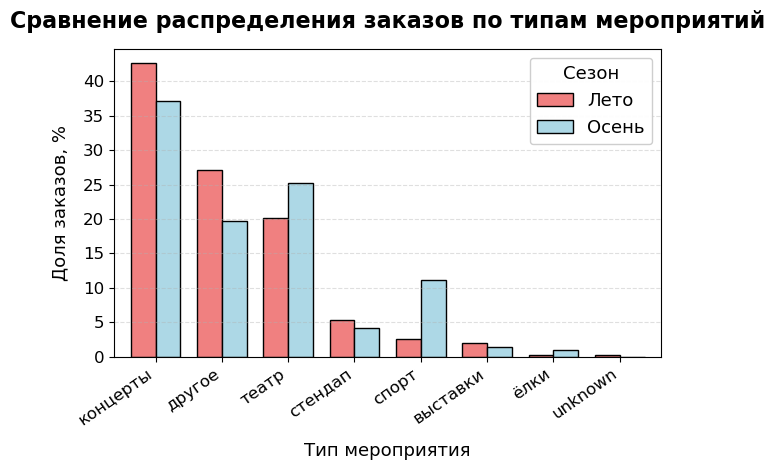

In [46]:
summer = clean_frame[clean_frame['season'] == 'лето']
autumn = clean_frame[clean_frame['season'] == 'осень']

event_summer = summer['event_type_main'].value_counts(normalize=True).mul(100).round(1)
event_autumn = autumn['event_type_main'].value_counts(normalize=True).mul(100).round(1)

events_comparison = pd.DataFrame({'Лето': event_summer, 'Осень': event_autumn})
events_comparison = events_comparison.sort_values(['Лето', 'Осень'], ascending=False)

plt.figure(figsize=(30, 20), dpi=120)
ax = events_comparison.plot(
    kind='bar',
    width=0.75,
    color=['lightcoral', 'lightblue'],
    edgecolor='black'
)

plt.title('Сравнение распределения заказов по типам мероприятий', pad=15, fontsize=16, fontweight='bold')
plt.xlabel('Тип мероприятия', labelpad=10, fontsize=13)
plt.ylabel('Доля заказов, %', labelpad=10, fontsize=13)
plt.xticks(rotation=35, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(['Лето', 'Осень'], fontsize=13, framealpha=0.95, loc='upper right', title='Сезон', title_fontsize=13)
plt.tight_layout()
plt.show()

На этой диаграмме видно, чтов большинстве категорий мероприятий значения достаточно близки друг к другу, но летом куда популярнее концерты, хотя осенью они также в лидерах среди всех мерпоприятий. Помимо этого театр и спортивные мероприятия показывают положительную динамику и увеличение спроса. Смею предположить, что это обусловлено закрытостью площадок проведения.

In [47]:
device_summer = summer['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)
device_autumn = autumn['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)

types_comparison = pd.DataFrame({'Лето': device_summer, 'Осень': device_autumn})
display(types_comparison)

Лето  Осень
device_type_canonical             
mobile                 80.6   79.7
desktop                19.4   20.3

Посмотрим на распределение заказов по типам устройств.

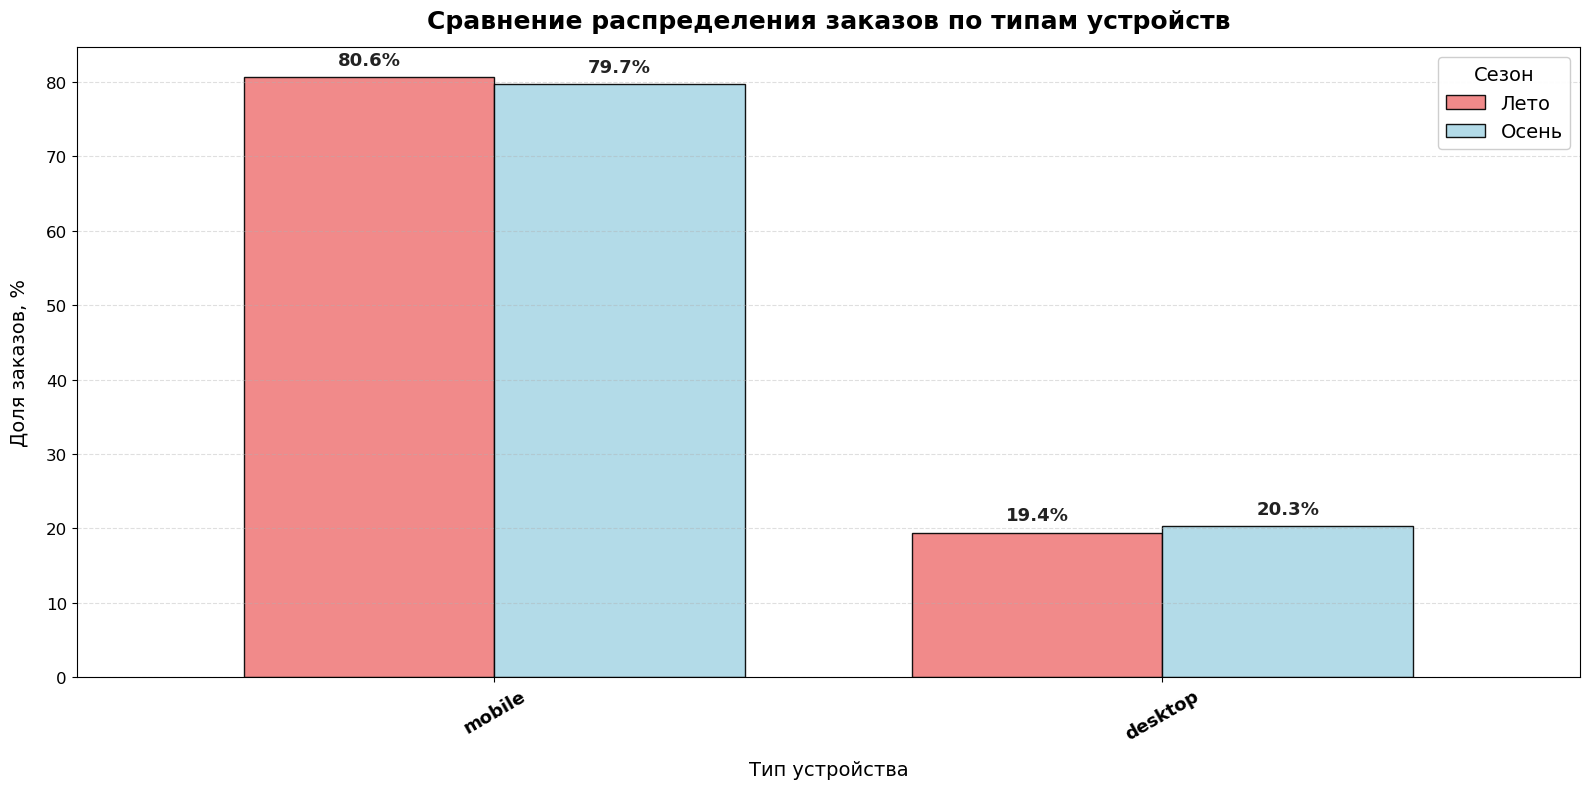

In [48]:
types_comparison_sorted = types_comparison.sort_values(['Лето', 'Осень'], ascending=False)

fig, ax = plt.subplots(figsize=(16, 8))
types_comparison.plot(
    kind='bar',
    ax=ax,
    width=0.75,
    color=['lightcoral', 'lightblue'],
    edgecolor='black',
    alpha=0.92
)

plt.title('Сравнение распределения заказов по типам устройств', pad=14, fontsize=18, fontweight='bold')
plt.xlabel('Тип устройства', labelpad=12, fontsize=14)
plt.ylabel('Доля заказов, %', labelpad=12, fontsize=14)
plt.xticks(rotation=30, ha='center', fontsize=13, fontweight='bold')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.legend(framealpha=0.95, fontsize=14, loc='upper right', title='Сезон', title_fontsize=14)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{height:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center', va='bottom',
            fontsize=13, fontweight='bold',
            color='#222',
            xytext=(0, 6),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

Из графика можно сделать вывод о том, что сезонность не оказыает особого влияния на заказы, но при этом пользователей мобильных устройств куда больше. Теперь обратим внимание на возрастные категории пользователей.

In [49]:
age_summer = summer['age_limit'].value_counts(normalize=True).mul(100).round(1)
age_autumn = autumn['age_limit'].value_counts(normalize=True).mul(100).round(1)

ages_comparison = pd.DataFrame({'Лето': age_summer, 'Осень': age_autumn})
display(ages_comparison)

Лето  Осень
age_limit             
0          17.9   23.6
6          18.2   17.6
12         20.6   22.1
16         28.3   26.2
18         15.0   10.4

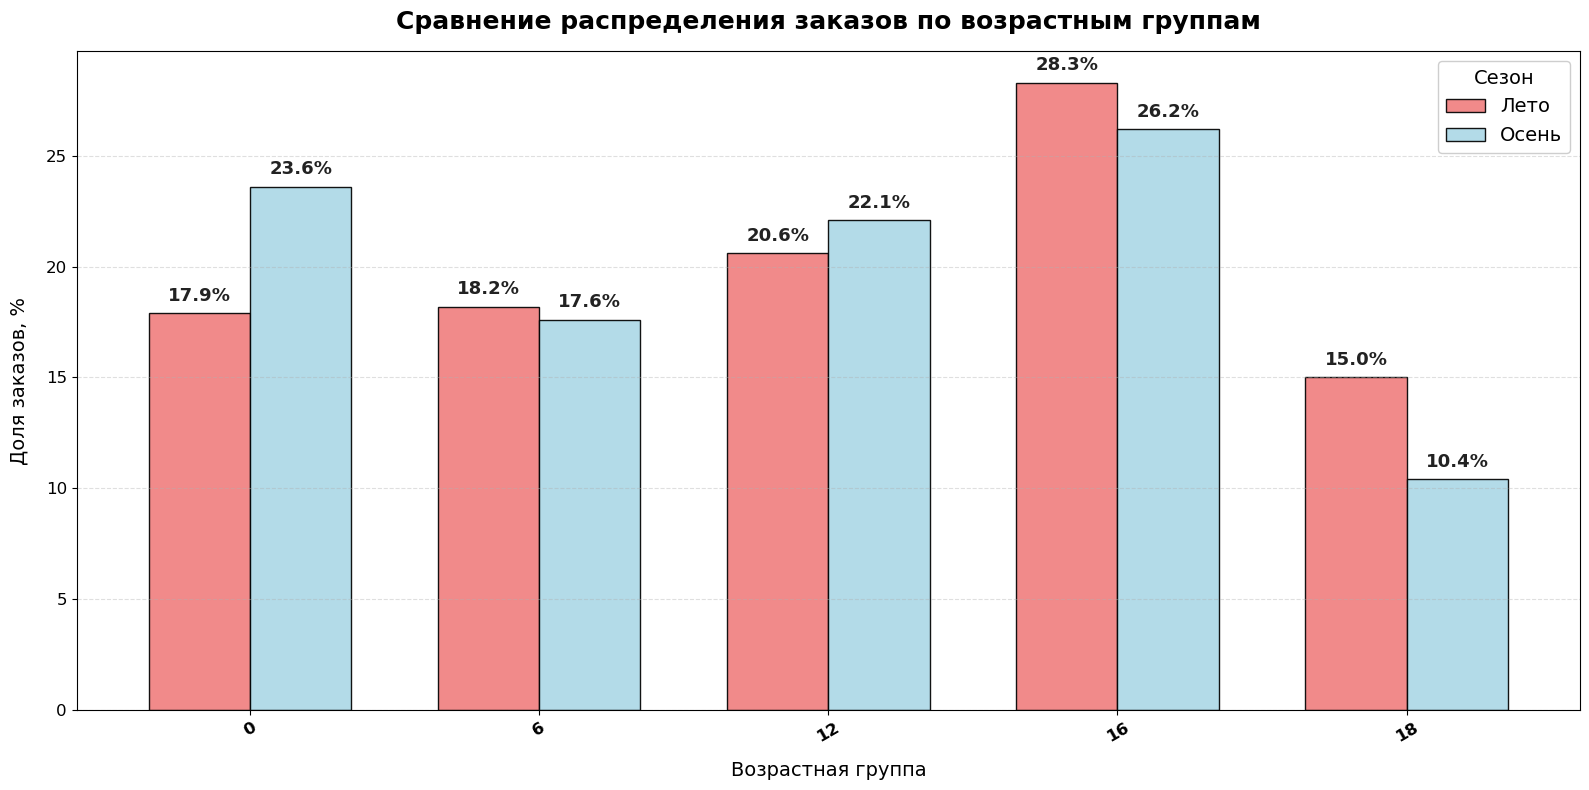

In [50]:
fig, ax = plt.subplots(figsize=(16, 8))

ages_comparison.plot(
    kind='bar',
    ax=ax,
    width=0.7,
    color=['lightcoral', 'lightblue'],
    edgecolor='black',
    alpha=0.92
)

plt.title('Сравнение распределения заказов по возрастным группам', pad=16, fontsize=18, fontweight='bold')
plt.xlabel('Возрастная группа', labelpad=12, fontsize=14)
plt.ylabel('Доля заказов, %', labelpad=12, fontsize=14)
plt.xticks(rotation=30, ha='center', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.legend(framealpha=0.95, fontsize=14, loc='upper right', title='Сезон', title_fontsize=14)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{height:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center', va='bottom',
            fontsize=13, fontweight='bold',
            color='#222',
            xytext=(0, 6),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

На этом графике наглядно видно, что большая часть заказов актуальна для пользователей возрастной группы - 16  лет. Также мы видим достаточно большое количество заказов в группе 0-6, скорее всего это заказы для детей в осенний период. 

Теперь обратимся к выручке.

In [51]:
mean_revenue = clean_frame.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().unstack()
display(mean_revenue)

season                  лето       осень
event_type_main                         
unknown             3.611663   15.055038
выставки           86.416198   90.603610
другое            106.131213  103.283277
концерты         1082.258038  334.635596
спорт              79.013391   74.346054
стендап           221.875294  231.124973
театр             214.457364  175.969508
ёлки              271.436176  229.585589

In [52]:
revenue_change = (mean_revenue['осень'] / mean_revenue['лето'] - 1) *100

display(revenue_change)

event_type_main
unknown     316.845057
выставки      4.845634
другое       -2.683410
концерты    -69.079870
спорт        -5.907021
стендап       4.168864
театр       -17.946624
ёлки        -15.418205
dtype: float64

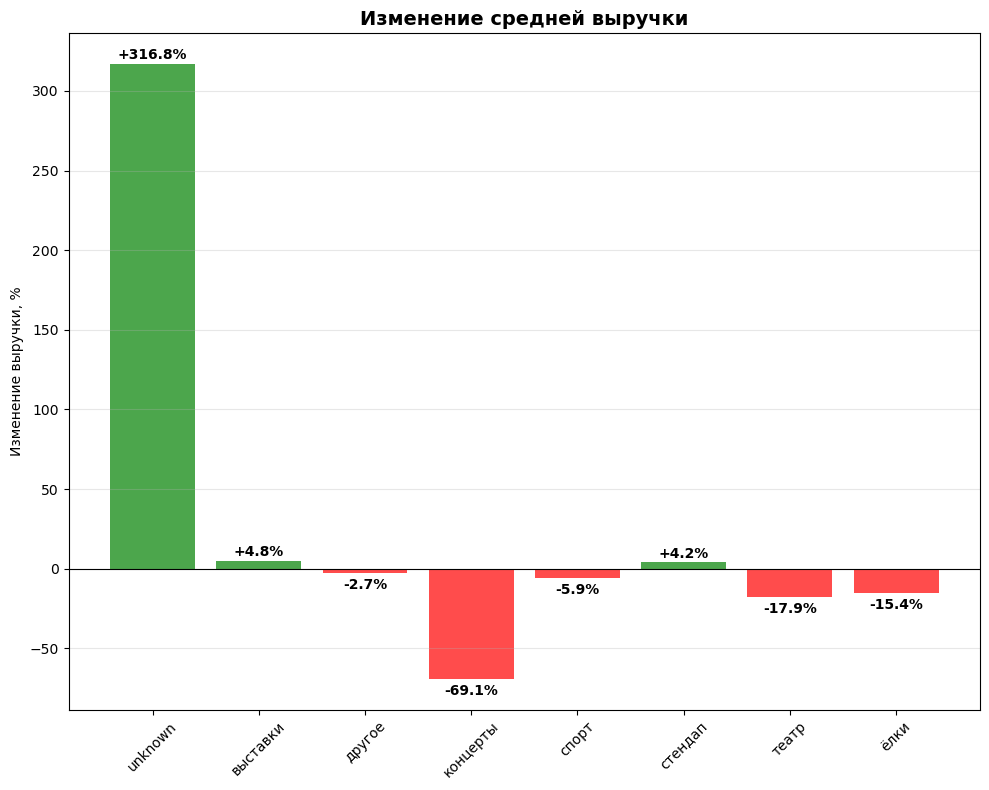

In [53]:
plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in revenue_change]
bars = plt.bar(revenue_change.index, revenue_change, color=colors, alpha=0.7)

plt.title('Изменение средней выручки', fontsize=14, fontweight='bold')
plt.ylabel('Изменение выручки, %')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar, change in zip(bars, revenue_change):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + (1 if bar.get_height() >= 0 else -3),
             f'{change:+.1f}%', 
             ha='center', 
             va='bottom' if bar.get_height() >= 0 else 'top',
             fontweight='bold')

plt.tight_layout()
plt.show()

На графике наглядно видно, что наибольший прирост средней выручки показывают мероприятия, не относящиеся к какой-либо одной конкретной категории и отнесенные к unknown(+316%). Также небольшой прирост выручки показали выставки (4.8%) и стендапы (4.2).
Остальные же категории мероприятий осенью показывают падение средней выручки. Наибольшее падение средней выручки показывают концерты (-69.1%).

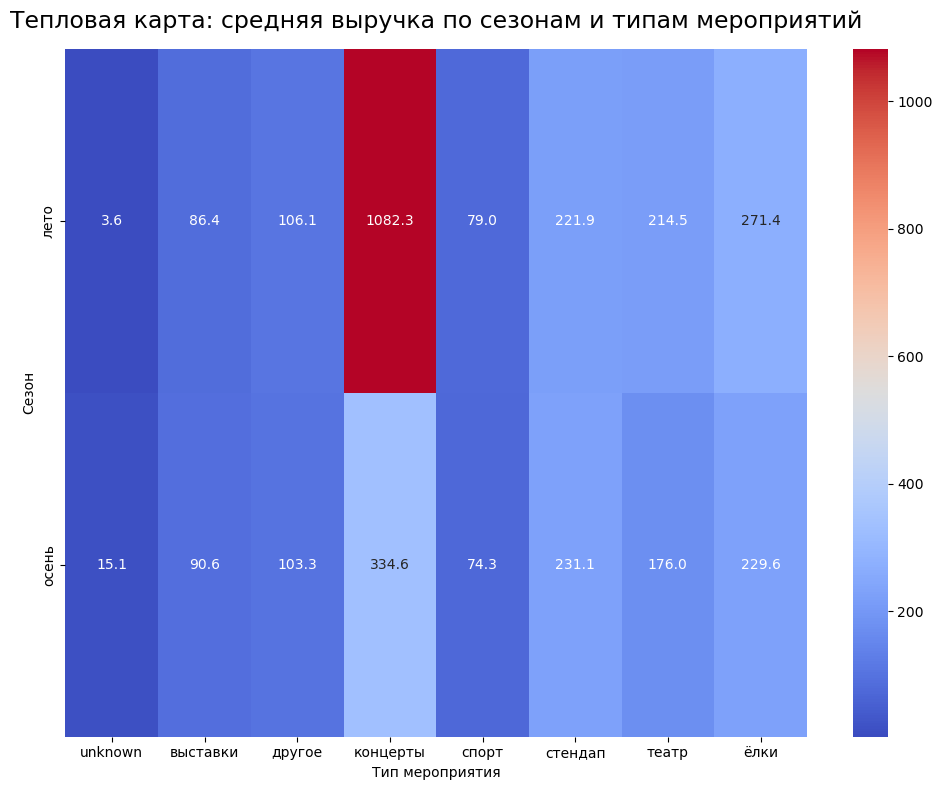

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(mean_revenue.transpose(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Тепловая карта: средняя выручка по сезонам и типам мероприятий', fontsize=17, pad=15)
plt.xlabel('Тип мероприятия')
plt.ylabel('Сезон')
plt.tight_layout()
plt.show()

**Промежуточный вывод:** 
- Kонцерты демонстрируют резкое падение выручки: Лето: 1 082 руб., Осень: 335 руб.
Возможные причины: Концерты перемещаются на закрытые площадки и они куда популярнее летом под открытым небом. 
- Театр и ёлки также дешевеют осенью: Театр: 215 руб. → 176 руб. Ёлки: 271 руб. → 230 руб.
Скорее всего театры и елки проводятся в конце осени или в её ходе куда как в большем количестве, из-за чего естественным образом снижается цена на билет.

### Осенняя активность пользователей

Посмотрим внимательнее на активность пользователей в Осенний период. Для этого создадим копию фрейма и выделим только осень.

In [55]:
autumn_frame = clean_frame[clean_frame['season'] == 'осень'].copy()

In [56]:
autumn_frame['date'] = pd.to_datetime(autumn_frame['created_dt_msk'])   

In [57]:
autumn_frame.head()

order_id          user_id created_dt_msk      created_ts_msk  event_id  \
2   7292370  0005ca5e93f2cf4     2024-10-06 2024-10-06 13:56:02    578454   
4    972400  000898990054619     2024-10-04 2024-10-04 22:33:15    509453   
5   2613713  000898990054619     2024-10-23 2024-10-23 15:12:00    500862   
7   4657981  000a55a418c128c     2024-09-29 2024-09-29 19:39:12    265857   
8   4657952  000a55a418c128c     2024-10-15 2024-10-15 10:29:04    271579   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  ...  \
2            нет          0           rub                mobile  1258.57  ...   
4            нет         18           rub                mobile  1390.41  ...   
5            нет         12           rub                mobile   902.74  ...   
7            нет         12           rub                mobile    47.78  ...   
8            нет         12           rub                mobile    74.84  ...   

                  venue_address       data  nominal     curs  cdx revenue_rub  \
2        алл. Юбилейная, д. 5/6 2024-10-06      100  19.6475  kzt     1258.57   
4  ш. Набережное, д. 595 стр. 8 2024-10-04      100  19.6648  kzt     1390.41   
5    бул. Отрадный, д. 4 стр. 1 2024-10-23      100  20.0531  kzt      902.74   
7          ул. О.Кошевого, д. 7 2024-09-29      100  19.3741  kzt       47.78   
8          ул. О.Кошевого, д. 7 2024-10-15      100  19.7185  kzt       74.84   

  one_ticket_revenue_rub month season       date  
2             314.642500    10  осень 2024-10-06  
4             463.470000    10  осень 2024-10-04  
5             300.913333    10  осень 2024-10-23  
7              47.780000     9  осень 2024-09-29  
8              37.420000    10  осень 2024-10-15  

[5 rows x 33 columns]

In [58]:
orders_per_user_per_day = autumn_frame.groupby(['date', 'user_id']).agg(
    user_orders=('order_id', 'count')
).reset_index()
daily_stats = orders_per_user_per_day.groupby('date').agg(
    total_orders=('user_orders', 'sum'),
    unique_users=('user_id', 'nunique'),
    avg_orders=('user_orders', 'mean'),  
).reset_index()
avg_revenue = autumn_frame.groupby('date')['revenue'].mean().reset_index()
daily_stats = daily_stats.merge(avg_revenue, on='date')
display(daily_stats)

date  total_orders  unique_users  avg_orders     revenue
0  2024-09-01          1327           564    2.352837  552.804687
1  2024-09-02          1380           574    2.404181  563.735848
2  2024-09-03          5111           778    6.569409  240.496361
3  2024-09-04          1773           685    2.588321  535.867597
4  2024-09-05          1944           739    2.630582  569.074666
..        ...           ...           ...         ...         ...
56 2024-10-27          2849          1034    2.755319  517.871839
57 2024-10-28          2838           985    2.881218  482.646963
58 2024-10-29          2836           998    2.841683  483.908614
59 2024-10-30          2928          1040    2.815385  519.440936
60 2024-10-31          5961          1272    4.686321  395.831084

[61 rows x 5 columns]

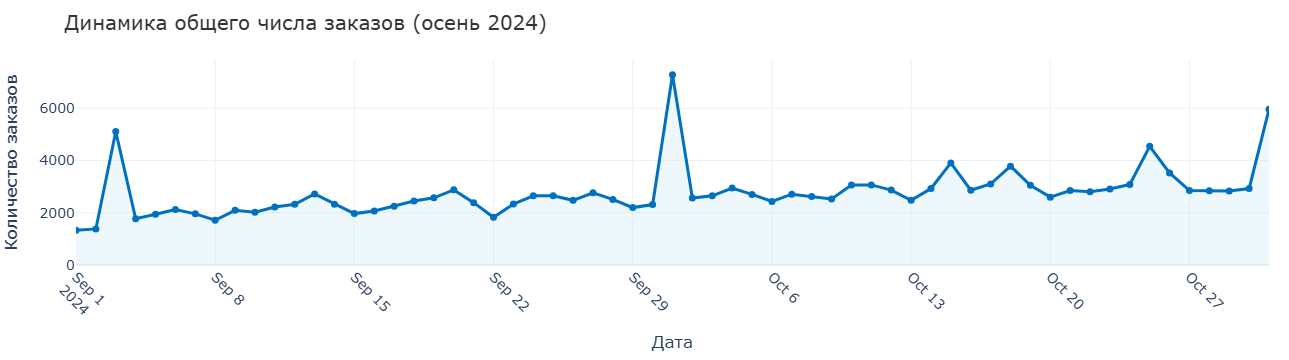

In [59]:
fig_orders = go.Figure()

fig_orders.add_trace(
    go.Scatter(
        x=daily_stats['date'],
        y=daily_stats['total_orders'],
        mode='lines+markers',
        line=dict(color='#0070C0', width=3),
        marker=dict(symbol='circle', size=7, color='#0070C0'),
        fill='tozeroy',
        fillcolor='rgba(199,229,243,0.3)',
        name='Заказы'
    )
)

fig_orders.update_layout(
    title='Динамика общего числа заказов (осень 2024)',
    xaxis_title='Дата',
    yaxis_title='Количество заказов',
    template='plotly_white',
    title_font=dict(size=20, color='#333'),
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(t=60, b=40, l=70, r=20)
)

fig_orders.show()

На графике видно, что пик заказов приходится на 3 сентября, 1 октября и 31 октября. Это может быть связано с праздниками, как глобальными, так и местными. При этом наблюдается тенденция к росту количества заказов.

In [60]:
fig_users = go.Figure()

fig_users.add_trace(
    go.Scatter(
        x=daily_stats['date'],
        y=daily_stats['unique_users'],
        mode='lines+markers',
        line=dict(color='#228B22', width=3),
        marker=dict(symbol='square', size=7, color='#228B22'),
        fill='tozeroy',
        fillcolor='rgba(169,231,181,0.25)',
        name='Уникальные пользователи'
    )
)

fig_users.update_layout(
    title='Динамика количества активных пользователей (DAU)',
    xaxis_title='Дата',
    yaxis_title='Уникальные пользователи',
    template='plotly_white',
    title_font=dict(size=20, color='#333'),
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(t=60, b=40, l=70, r=20)
)

fig_users.show()

- Количество пользователей также показывает тенденцию к росту.
- Пик приходится на 31 октября - 1282 пользователя.
- Прирост пользователей скачкообразный с пиками каждые 5-6 дней, при этом пики приходятся на середину недели, а не на выходные.

In [61]:
fig_orders = go.Figure()
fig_orders.add_trace(go.Scatter(
    x=daily_stats['date'],
    y=daily_stats['avg_orders'],
    mode='lines+markers',
    line=dict(color='#1f77b4', width=3),
    marker=dict(symbol='square', size=7, color='#1f77b4'),
    fill='tozeroy',
    fillcolor='rgba(31, 119, 180, 0.25)',
    name='Среднее число заказов'
))
fig_orders.update_layout(
    title='Среднее число заказов на пользователя по дням',
    xaxis_title='Дата',
    yaxis_title='Среднее число заказов',
    template='plotly_white',
    title_font=dict(size=20, color='#333'),
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(t=60, b=40, l=70, r=20)
)
fig_orders.show()

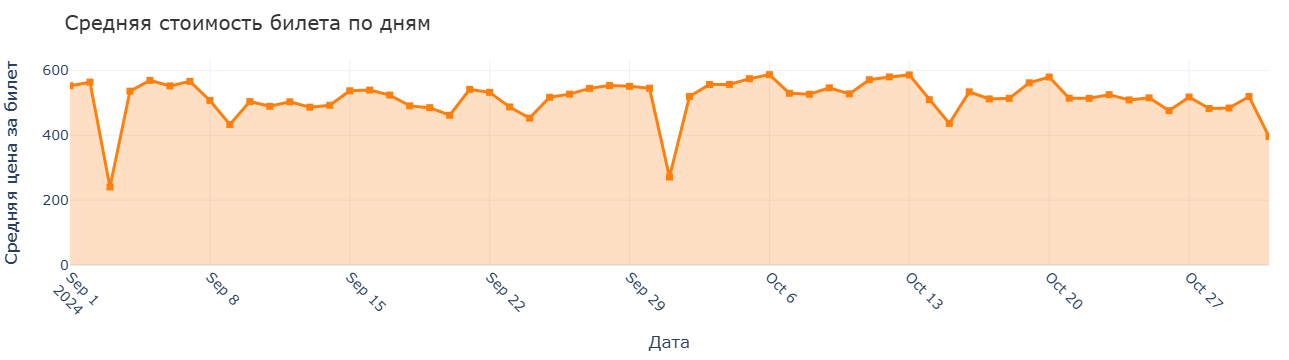

In [62]:
fig_revenue = go.Figure()
fig_revenue.add_trace(go.Scatter(
    x=daily_stats['date'],
    y=daily_stats['revenue'],
    mode='lines+markers',
    line=dict(color='#ff7f0e', width=3),
    marker=dict(symbol='square', size=7, color='#ff7f0e'),
    fill='tozeroy',
    fillcolor='rgba(255, 127, 14, 0.25)',
    name='Средняя цена за билет'
))
fig_revenue.update_layout(
    title='Средняя стоимость билета по дням',
    xaxis_title='Дата',
    yaxis_title='Средняя цена за билет',
    template='plotly_white',
    title_font=dict(size=20, color='#333'),
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(t=60, b=40, l=70, r=20)
)
fig_revenue.show()

На визуализациях наглядно видно, что пик числа заказов приходится на дни, когда цена на билеты была снижена.

In [63]:
autumn_frame['day_of_week'] = autumn_frame['date'].dt.dayofweek
autumn_frame['day_name'] = autumn_frame['date'].dt.day_name()  
autumn_frame['is_weekend'] = autumn_frame['day_of_week'].isin([5, 6])

In [64]:
weekday_stats = autumn_frame.groupby(['day_name', 'is_weekend']).agg(
                total_orders=('order_id', 'count'),
                unique_users=('user_id', 'nunique'),
                total_revenue=('revenue_rub', 'sum')).reset_index()
weekday_stats['total_revenue'] = weekday_stats['total_revenue'].round(2)
weekday_stats['avg_orders_per_user'] = weekday_stats['total_orders'] / weekday_stats['unique_users']
weekday_stats['avg_orders_per_user'] = weekday_stats['avg_orders_per_user'].round(2)
weekday_stats['avg_revenue_per_user'] = weekday_stats['total_revenue'] / weekday_stats['unique_users']
weekday_stats['avg_revenue_per_user'] = weekday_stats['avg_revenue_per_user'].round(2)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['day_name'] = pd.Categorical(weekday_stats['day_name'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('day_name')
weekday_stats

day_name  is_weekend  total_orders  unique_users  total_revenue  \
1     Monday       False         21517          4448    12065864.59   
5    Tuesday       False         31480          4793    14253924.19   
6  Wednesday       False         22888          4813    13936686.80   
4   Thursday       False         27169          4970    15645327.93   
0     Friday       False         24828          4870    15154237.41   
2   Saturday        True         21336          4571    12971148.21   
3     Sunday        True         19389          4394    11829296.96   

   avg_orders_per_user  avg_revenue_per_user  
1                 4.84               2712.65  
5                 6.57               2973.90  
6                 4.76               2895.63  
4                 5.47               3147.95  
0                 5.10               3111.75  
2                 4.67               2837.70  
3                 4.41               2692.15

#### **Промежуточный вывод:** 
- Из полученных данных видим, что по количеству заказов лидирует вторник (31480)
- Больше всего пользователей в четверг(4970), чуть меньше в среду(4813) и пятницу(4870).
- Наибольшая выручка в четверг(15,645,327.96) и пятницу(15,154,237.43).
- В среднем по числу заказов на человека также лидирует вторник (6.57).
- Средняя выручка на пользователя наибольшая в четверг (3,147.95)

### Популярные события и партнеры

Теперь посмотрим на события в разрезе регионов - какие регионы по событиям в топе и какой тип событий наиболее популярен.

In [65]:
region_stats = autumn_frame.groupby('region_name').agg(
               unique_events=('event_id', 'nunique'),
               total_orders=('order_id', 'count'),
               unique_users=('user_id', 'nunique')).reset_index().sort_values('unique_events', ascending=False)

region_stats

region_name  unique_events  total_orders  unique_users
24        Каменевский регион           3910         46684          6994
60      Североярская область           2613         20718          4019
76       Широковская область            803          8715          2063
57      Светополянский округ            764          4779          1192
52       Речиновская область            529          3565          1030
..                       ...            ...           ...           ...
18            Залесский край              4            56            24
0                    unknown              4            22            15
56         Светолесский край              2            18            10
6          Верхозёрский край              2            11             5
66  Сосноводолинская область              1             9             6

[80 rows x 4 columns]

In [66]:
top_5 = region_stats.head(5)

In [67]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_5['region_name'],
    y=top_5['unique_events'],
    marker_color='#4e79a7',
    opacity=0.85
))

fig.update_layout(
    title='Топ-5 регионов по разнообразию мероприятий',
    xaxis_title='Регион',
    yaxis_title='Количество уникальных мероприятий',
    template='simple_white',
    title_font=dict(size=18, family='Arial'),
    font=dict(size=14, family='Arial'),
    xaxis_tickangle=45,
    margin=dict(l=60, r=30, t=70, b=60),
    plot_bgcolor='white',
    showlegend=False
)

fig.update_xaxes(showline=False, linewidth=0, linecolor='black', showgrid=False)
fig.update_yaxes(showline=False, linewidth=0, linecolor='black', gridcolor='rgba(0,0,0,0.15)', gridwidth=1)

fig.show()

По количеству уникальных мероприятий лидирует Каменевский регион (3910).Также в топ-5 находится Североярская область (2613), Широковская область (803), Светополянский округ (764) и Речиновская область(529).
Между первым местом в топе и 5 - огромный разрыв по количеству мероприятий. Это может быть связано как с социальными причинами(больше населения или более развитый регион), так и с иными.

In [68]:
total_events = autumn_frame['event_id'].nunique()
total_orders = autumn_frame['order_id'].count()

region_stats = autumn_frame.groupby('region_name').agg(
               region_events=('event_id', 'nunique'),
               region_orders=('order_id', 'count')).reset_index()

region_stats['events_share'] = (region_stats['region_events'] / total_events * 100).round(2)
region_stats['orders_share'] = (region_stats['region_orders'] / total_orders * 100).round(2)

In [69]:
top_regions_events = region_stats.sort_values('events_share', ascending=False).head(5)
display(top_regions_events[['region_name', 'events_share', 'orders_share']])

region_name  events_share  orders_share
24    Каменевский регион         24.62         27.69
60  Североярская область         16.45         12.29
76   Широковская область          5.06          5.17
57  Светополянский округ          4.81          2.83
52   Речиновская область          3.33          2.11

In [70]:
other_events = total_events - top_regions_events['region_events'].sum()
other_orders = total_orders - top_regions_events['region_orders'].sum()

other_row = {
    'region_name': 'Другие регионы',
    'events_share': (other_events / total_events * 100).round(2),
    'orders_share': (other_orders / total_orders * 100).round(2)
}

other_df = pd.DataFrame([other_row])
top_with_other = pd.concat([top_regions_events, other_df], ignore_index=True)

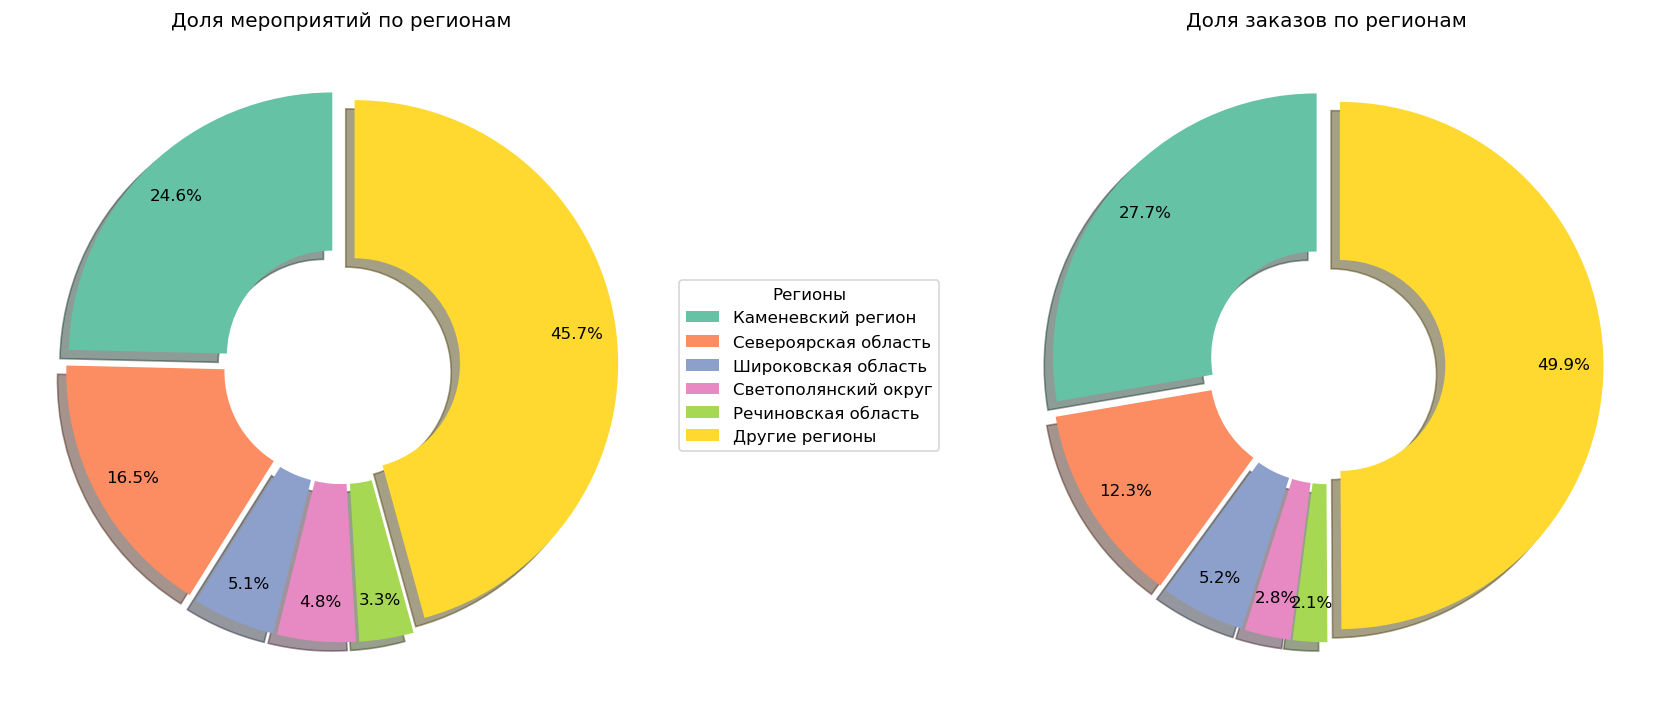

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=120)
wedgeprops = {'width': 0.6}
ax1.pie(top_with_other['events_share'],
        #labels=top_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90, 
        colors=sns.color_palette('Set2'),
        shadow=True,
       explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       wedgeprops=wedgeprops,
       pctdistance=0.85,)
ax1.set_title('Доля мероприятий по регионам')
ax1.legend(top_with_other['region_name'], 
           title="Регионы",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))
ax2.pie(top_with_other['orders_share'],
        #labels=top_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90, 
        colors=sns.color_palette('Set2'),
        shadow=True,
        explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       wedgeprops=wedgeprops,
       pctdistance=0.85,)
ax2.set_title('Доля заказов по регионам')

plt.tight_layout()
plt.show()

Промежуточный вывод: Доля мероприятий и доля заказов по-прежнему лидируют в Каменевском регионе (24.6% и 27.7%). При этом важно отметить что разрыв между прочими регионами и топ1 - более 10%. 

In [72]:
partner_stats = autumn_frame.groupby('service_name').agg(
                unique_events=('event_id', 'nunique'),
                total_orders=('order_id', 'count'),
                total_revenue=('revenue_rub', 'sum')).reset_index()
partner_stats['total_revenue'] = partner_stats['total_revenue'].round(2)
partner_stats = partner_stats.sort_values('total_revenue', ascending=False)
pd.set_option('display.float_format', '{:,.2f}'.format)
partner_stats.head()

service_name  unique_events  total_orders  total_revenue
3   Билеты без проблем           2847         32383  20,858,489.30
24           Мой билет           1006         19419  15,785,680.43
25             Облачко           1409         15478  10,611,051.69
21         Лови билет!           3616         25792  10,376,793.48
8       Весь в билетах            599          9406   9,325,570.66

In [73]:
top_5_part = partner_stats.sort_values('unique_events', ascending=False).head(5)
display(top_5_part)

service_name  unique_events  total_orders  total_revenue
21         Лови билет!           3616         25792  10,376,793.48
3   Билеты без проблем           2847         32383  20,858,489.30
5        Билеты в руки           2471         25734   7,613,965.50
25             Облачко           1409         15478  10,611,051.69
22       Лучшие билеты           1397         12445   1,676,010.07

In [74]:
fig = px.bar(top_5_part,
             x='service_name',
             y='unique_events',
             title='Топ-5 партнеров по разнообразию мероприятий',
             labels={'service_name': 'Партнер', 'unique_events': 'Количество уникальных мероприятий'},
             color_discrete_sequence=['lightgreen'])
fig.update_traces(opacity=0.75)
fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center', 'font': {'size': 14}},
    xaxis_tickangle=-45,
    plot_bgcolor='white',
    showlegend=False,
    width=800,
    height=500
)

fig.update_layout(yaxis_showgrid=True, 
                  yaxis_gridcolor='lightgray',
                  yaxis_gridwidth=1)

fig.show()

Здесь мы видим, что в топ-5 разрыв между компаниями не такой и резкий, как между регионами. Топ-1 - Лови билет! (3616), а топ-5 - Лучшие билеты (1397). При этом первые три места в топе провели более 2000 мероприятий.

In [75]:
top_5_part = partner_stats.sort_values('unique_events', ascending=False).head(5).copy()
total_events = partner_stats['unique_events'].sum()
total_orders = partner_stats['total_orders'].sum()
total_revenue = partner_stats['total_revenue'].sum()
top_5_part['events_percent, %'] = (top_5_part['unique_events'] / total_events * 100).round(2)
top_5_part['orders_percent, %'] = (top_5_part['total_orders'] / total_orders * 100).round(2)
top_5_part['revenue_percent, %'] = (top_5_part['total_revenue'] / total_revenue * 100).round(2)
pd.set_option('display.float_format', '{:,.2f}'.format)
display(top_5_part[['service_name', 'unique_events', 'events_percent, %', 
                    'total_orders', 'orders_percent, %', 
                    'total_revenue', 'revenue_percent, %']])

service_name  unique_events  events_percent, %  total_orders  \
21         Лови билет!           3616              20.90         25792   
3   Билеты без проблем           2847              16.45         32383   
5        Билеты в руки           2471              14.28         25734   
25             Облачко           1409               8.14         15478   
22       Лучшие билеты           1397               8.07         12445   

    orders_percent, %  total_revenue  revenue_percent, %  
21              15.30  10,376,793.48               10.83  
3               19.21  20,858,489.30               21.76  
5               15.26   7,613,965.50                7.94  
25               9.18  10,611,051.69               11.07  
22               7.38   1,676,010.07                1.75

**Вывод:** В топ-5 попали компании-партнеры с наибольшим количеством мероприятий. 
- Топ-1 строчку занимает Лови билет! с 3616 мероприятиями, что составляет 20.90 % от всех мероприятий. 
- При этом по количеству заказов лидирует другая фирма с названием "Билеты без проблем!" (32383) что составляет 19.21% от всех заказов. 
- По выручке лидирует также "Билеты без проблем" (20,858,489.26), что составляет 21.76% выручки от общей выручки. 

## Статистический анализ данных

**Необходимо проверить две гипотезы:**
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

### Проверка гипотезы №1.

- **Нулевая гипотеза (H₀):** Среднее количество заказов на одного пользователя мобильного приложения не выше среднего количества заказов на одного пользователя стационарных устройств.
μ_mobile = μ_desktop

- **Альтернативная гипотеза (H₁):** Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
μ_mobile > μ_desktop

In [76]:
user_orders = autumn_frame.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()
user_orders.head()

user_id device_type_canonical  order_id
0  0005ca5e93f2cf4                mobile         1
1  000898990054619                mobile         2
2  000a55a418c128c                mobile         2
3  001e7037d013f0f                mobile         2
4  00245c702bc343e                mobile         2

In [77]:
mobile_orders = user_orders[user_orders['device_type_canonical'] == 'mobile']['order_id']
desktop_orders = user_orders[user_orders['device_type_canonical'] == 'desktop']['order_id']

In [78]:
display(pd.DataFrame({'mobile': mobile_orders,'desktop': desktop_orders}).describe())

mobile  desktop
count 14,190.00 4,869.00
mean       9.46     7.05
std       68.06    35.99
min        1.00     1.00
25%        1.00     1.00
50%        2.00     2.00
75%        5.00     4.00
max    4,336.00 1,502.00

In [79]:
fig = px.histogram(user_orders, x='device_type_canonical', 
                   color='device_type_canonical',
                   color_discrete_map={'mobile': 'lightcoral', 'desktop': 'lightgreen'},
                   title='Распределение числа заказов по типу устройства',
                   labels={'device_type_canonical': 'Тип устройства', 'count': 'Количество заказов'})

fig.update_layout(bargap=0.1)
fig.show()

In [80]:
fig = px.box(user_orders, x='device_type_canonical', y='order_id',
             color='device_type_canonical',
             color_discrete_map={'mobile': 'lightcoral', 'desktop': 'lightgreen'},
             title='Ящик с усами',
             labels={'device_type_canonical': 'Тип устройства', 'order_id': 'Число заказов'},
             range_y=[0, 20])

fig.show()

На графике наглядно видно, что доля заказов с мобильного устройства выше, чем с десктопа. При этом важно заметить, что медиана одинакова для обоих категорий (2). А вот третий квартиль уже различается - 5 у мобильных устройств против 4 у десктопа. 

Для проведения теста выбира Манна-Уитни, поскольку тест Уэлча чувствителен к выбросам, здесь же у нас есть и выбросы и высокое стандартное отклонение.

In [81]:
alpha = 0.05
stat, p_value = mannwhitneyu(mobile_orders, 
                            desktop_orders,
                            alternative='greater')
print(f'p-value: {p_value:.8f}') 
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее количество заказов мобильных пользователей значимо выше")
else:
    print("Не отвергаем нулевую гипотезу: нет доказательств, что среднее количество заказов мобильных пользователей значимо выше")

p-value: 0.00000034
Отвергаем нулевую гипотезу: среднее количество заказов мобильных пользователей значимо выше


### Проверка гипотезы №2

- **Нулевая гипотеза (H₀):** Среднее время между заказами пользователей мобильных приложений не выше среднего времени между заказами пользователей стационарных устройств. μ_mobile = μ_desktop

- **Альтернативная гипотеза (H₁):** Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств. μ_mobile > μ_desktop

In [82]:
user_order_counts = autumn_frame['user_id'].value_counts()
users_with_multiple_orders = user_order_counts[user_order_counts > 1].index

df_filter = autumn_frame[autumn_frame['user_id'].isin(users_with_multiple_orders)]

In [83]:
mobile_users = df_filter[df_filter['device_type_canonical'] == 'mobile']
desktop_users = df_filter[df_filter['device_type_canonical'] == 'desktop']

In [84]:
mobile_ids = set(mobile_users['user_id'])
desktop_ids = set(desktop_users['user_id'])
common_users = mobile_ids & desktop_ids
print(f"Количество пользователей в обеих группах: {len(common_users)}")
only_mobile = mobile_ids - desktop_ids
print(f"Только mobile: {len(only_mobile)}")
only_desktop = desktop_ids - mobile_ids
print(f"Только desktop: {len(only_desktop)}")

Количество пользователей в обеих группах: 3250
Только mobile: 5567
Только desktop: 579


In [85]:
hybrid_users = set(mobile_users['user_id']) & set(desktop_users['user_id'])
df_filter_clean = df_filter[~df_filter['user_id'].isin(hybrid_users)]

In [86]:
mobile_clean_users = df_filter_clean[df_filter_clean['device_type_canonical'] == 'mobile']
desktop_clean_users = df_filter_clean[df_filter_clean['device_type_canonical'] == 'desktop']

In [87]:
print(f"NaN в mobile: {mobile_clean_users['days_since_prev'].isna().sum()}")
print(f"NaN в desktop: {desktop_clean_users['days_since_prev'].isna().sum()}")

NaN в mobile: 2797
NaN в desktop: 393


In [88]:
mobile_clean_users = mobile_clean_users.dropna(subset=['days_since_prev'])
desktop_clean_users = desktop_clean_users.dropna(subset=['days_since_prev'])

In [89]:
print(f"NaN в mobile: {mobile_clean_users['days_since_prev'].isna().sum()}")
print(f"NaN в desktop: {desktop_clean_users['days_since_prev'].isna().sum()}")

NaN в mobile: 0
NaN в desktop: 0


In [90]:
alpha = 0.05
u_stat, p_value = stats.mannwhitneyu(mobile_clean_users['days_since_prev'],
                                     desktop_clean_users['days_since_prev'],
                                     alternative='greater')

print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее время между заказами мобильных пользователей значимо выше")
else:
    print("Не отвергаем нулевую гипотезу: нет доказательств, что среднее время между заказами мобильных пользователей выше")

p-value: 0.0000
Отвергаем нулевую гипотезу: среднее время между заказами мобильных пользователей значимо выше


**Промежуточный вывод:**
- Гипотеза 1 подтвердилась и доля заказов с мобильных устройств действительно выше, чем с настольных платформ.
- Высокая t-статистика говорит о сильной разнице между группами — что также подтверждает нашу гипотезу о количестве заказов.
- Для проверки гипотез был выбран тест Манна-Уитни, поскольку он подходит для тестирования групп разных размеров выборок, и при этом не чувствителен к выбросам и высокому среднему отклонению.
- Гипотеза 2 также подтверждена: среднее время между заказами с мобильных действительно статистически выше, чем у пользователей десктопа. 

## Итоговый вывод и рекомендации

- Были представлены для обработки данные трех датасетов `final_tickets_orders_df.csv`, `final_tickets_events_df.csv`, `final_tickets_tenge_df.csv`, в которых представлена информация о бронировании билетов на сервисе Яндекс.Афиша за период с 1 июня по 30 октября 2024 года и которые представляют данные о заказах билетов, событиях, городах и регионах событий, площадках мероприятий, о курсе тенге к российскому рублю за 2024 год.
- Была проведена преобработка данных, в ходе которой датафреймы были объединены, проверены на пропуски и дубликаты. Помимо этого, была снижена разрядность некоторых столбцов и у двух столбцов изменен тип данных на дату. 
- После анализа распределения заказов были выявлены следующие закономерности: летом больше концертов, а осенью театр и спортивные мероприятия. Хотя при этом концертов в сравнении с другими мероприятиями значительно больше. Помимо этого, больше всего заказов в пятницу и четверг. Большая часть заказов актуальна для пользователей возрастной группы 16 лет. Также, очень много заказов от пользователей с возрастом 0-6 (их родителей, судя по всему).
- Также мы видим что осенью резко падает выручка от концертов и начинает расти выручкаот спортивных мероприятий и театра. 
- Осенью число заказов и количество активных пользователей неуклонно растет.
- по количеству заказов лидирует вторник
- Больше всего пользователей в четверг, чуть меньше в среду и пятницу.
- Наибольшая выручка в четверг и пятницу.
- В среднем по числу заказов на человека также лидирует вторник.
- Средняя выручка на пользователя наибольшая в четверг
- По количеству уникальных мероприятий лидирует Каменевский регион.Также в топ-5 находится Североярская область, Широковская область, Светополянский округ и Речиновская область. Между первым местом в топе и 5 - огромный разрыв по количеству мероприятий.
- Топ-1 среди кампаний - Лови билет!, а топ-5 - Лучшие билеты. При этом первые три места в топе провели более 2000 мероприятий.
- Топ-1 строчку занимает Лови билет!.
- При этом по количеству заказов лидирует другая фирма с названием "Билеты без проблем!".
- По выручке лидирует также "Билеты без проблем".
- Подтвердились гипотезы о том, что большая доля заказов происходит с мобильных устройств. При этом медиана одинакова (2).
- Также подтвердилась гипотеза о том, что между заказами с мобильных устройств проходит больше времени, чем с заказами с десктопа. Я бы связал это со спонтанностью и легкодоступностью заказа с мобильного телефона (платформы).

### Рекомендации:

- Обратить особое внимание на резкое снижение выручки с концертов. Возможно, стоит проанализировать непосредственно категорию концертов, чтобы понять причину резкого снижения.
- В осенний период обратить внимание на театр и спорт. 
- Следует расширить деятельность в топ-регионах, возможно следует увеличить маркетинг или проводить специальные акции для закрытых площадок, чтобы привлечь аудиторию. 
- Мобильные платформы чаще используются для заказов, хотя между заказами проходит больше времени, чем с настольных платформ. Следует проработать этот момент. Возможно, мобильное приложение требует доработки или дополнительного анализа пользователей на предмет заинтересованности или работы с UX/UI
- Усилить работу над десктопными вариантами - сайтом или приложением. Возможно, следует разработать специальные акции или предложения для пользователей с десктопа для привлечения пользователей и их вовлеченности. 